Scripts

In [1]:
from newsapi import NewsApiClient
import datetime
import time
import pandas as pd
import os
from newspaper import Article
import sys

In [ ]:
# Initialize NewsAPI Client
api_key = ""  # Replace with API key
newsapi = NewsApiClient(api_key=api_key)

# Input and output file paths
input_file = "news_articles_election_candidates_expanded.csv"
full_content_file = "news_articles_election_candidates_full_content.csv"

# Function to fetch full article content using newspaper3k
def fetch_full_content(article_url):
    try:
        article = Article(article_url)
        article.download()
        article.parse()
        return article.text  # Return the full article text
    except Exception as e:
        return None  # Return None if there is an error

# Set new date range
start_date = datetime.date(2024, 10, 12)  # Continue from where the previous script left off
end_date = datetime.date(2024, 8, 1)  # Adjust end date as needed for backward collection

# Prepare to store results
articles_data = []

# Expanded search queries
queries = [
    "2024 Presidential election",
    "US election AND (Donald Trump OR Kamala Harris)",
    "Biden administration AND 2024 election",
    "(Donald Trump OR Trump) AND 2024 election",
    "(Kamala Harris OR Harris) AND 2024 election",
    "Campaign financing AND 2024 election",
    "Voter turnout AND 2024 election",
    "Presidential debate AND 2024 election",
    "(Donald Trump OR Trump) AND rally AND 2024",
    "(Kamala Harris OR Harris) AND speech AND 2024",
    "(Donald Trump OR Kamala Harris) AND 2024 election",
    "(Trump OR Harris) AND campaign AND 2024 election"
]

# Track API request count to avoid exceeding limits
request_count = 0
max_requests = 100  # Free-tier daily API limit

# Load existing expanded and full content CSV files
existing_expanded_data = pd.read_csv(input_file) if os.path.exists(input_file) else pd.DataFrame()
existing_full_content_data = pd.read_csv(full_content_file) if os.path.exists(full_content_file) else pd.DataFrame()

# Track URLs to avoid duplicates
existing_urls = set(existing_expanded_data["url"]) if not existing_expanded_data.empty else set()
processed_urls = set(existing_full_content_data["url"]) if not existing_full_content_data.empty else set()

# Fetch new articles from NewsAPI
current_date = start_date
while current_date >= end_date:
    # Convert date to string for API
    date_str = current_date.strftime('%Y-%m-%d')
    print(f"Fetching articles for {date_str}...")

    for query in queries:
        try:
            # Check if API limit is reached
            if request_count >= max_requests:
                print("Reached API limit for the day. Exiting script.")
                sys.exit()

            # Fetch articles for the current query and date
            response = newsapi.get_everything(
                q=query,
                from_param=date_str,
                to=date_str,
                language="en",
                sort_by="relevancy",  # Fetch relevant articles
                page_size=100  # Max articles per API call
            )

            # Increment request count
            request_count += 1

            if response.get('status') != 'ok':
                print(f"API error: {response.get('message')}")
                sys.exit()

            # Process the articles
            if response.get('articles'):
                for article in response['articles']:
                    # Only add new articles that are not already saved
                    if article['url'] not in existing_urls:
                        articles_data.append({
                            "query": query,  # Include the query used for tracking
                            "source": article['source']['name'],
                            "author": article['author'],
                            "title": article['title'],
                            "description": article['description'],
                            "url": article['url'],
                            "published_at": article['publishedAt'],
                            "content": article['content']
                        })
                        # Add the URL to the set of existing URLs
                        existing_urls.add(article['url'])
        except Exception as e:
            # Log the error to a file
            with open("error_log.txt", "a") as log_file:
                log_file.write(f"Error fetching articles for {query} on {date_str}: {e}\n")
            print(f"Error fetching articles for {query} on {date_str}: {e}")
    
    # Move to the previous day
    current_date -= datetime.timedelta(days=1)

    # Avoid hitting API limits by adding a small delay between requests
    time.sleep(1)

# Save new articles to the expanded CSV file
if articles_data:
    new_data_df = pd.DataFrame(articles_data)
    new_data_df.to_csv(input_file, mode='a', header=not os.path.exists(input_file), index=False)
    print(f"Appended {len(new_data_df)} new articles to '{input_file}'.")

# Extract full content for new articles only
new_urls = {article["url"] for article in articles_data}  # URLs of newly fetched articles
urls_to_process = new_urls - processed_urls  # Exclude already processed URLs

if urls_to_process:
    full_content_data = []
    for url in urls_to_process:
        print(f"Fetching full content for {url}...")
        full_content = fetch_full_content(url)
        if full_content:
            full_content_data.append({
                "url": url,
                "full_content": full_content
            })
        else:
            print(f"Failed to fetch full content for {url}")

    # Append full content to the full content CSV file
    if full_content_data:
        full_content_df = pd.DataFrame(full_content_data)
        full_content_df.to_csv(full_content_file, mode='a', header=not os.path.exists(full_content_file), index=False)
        print(f"Appended {len(full_content_df)} new full content articles to '{full_content_file}'.")
else:
    print("No new articles to process for full content.")



Remove entries with missing full content

START

In [45]:
import pandas as pd
data_full_content = pd.read_csv('news_articles_election_candidates_full_content_cleaned.csv')
data_full_content.head()

query            source  \
0  2024 Presidential election             Wired   
1  2024 Presidential election         The Verge   
2  2024 Presidential election               NPR   
3  2024 Presidential election  Business Insider   
4  2024 Presidential election              CNET   

                                              author  \
0                         Lily Hay Newman, Tess Owen   
1                                      Justine Calma   
2                                        Megan Pratz   
3  insider@insider.com (John L. Dorman,Kelsey Vla...   
4                                        Thomas Kika   

                                               title  \
0  Russia Is Going All Out on Election Day Interf...   
1  Apple News will let you watch election results...   
2  Here's how NPR will report the 2024 election r...   
3  The 2024 presidential election may come down t...   
4  How Do I Keep Track of Official Election Resul...   

                                         description  \
0  Along with other foreign influence operations—...   
1  On Election Day in the US, Apple News is rolli...   
2  NPR relies on results and race calls from The ...   
3  Election results in the swing states of Arizon...   
4  An avalanche of Election Day 2024 coverage is ...   

                                                 url          published_at  \
0  https://www.wired.com/story/russia-election-di...  2024-11-05T21:04:35Z   
1  https://www.theverge.com/2024/11/5/24288777/el...  2024-11-05T16:34:12Z   
2  https://www.npr.org/2024/11/04/g-s1-31268/2024...  2024-11-05T10:00:00Z   
3  https://www.businessinsider.com/what-are-2024-...  2024-11-05T22:13:18Z   
4  https://www.cnet.com/tech/services-and-softwar...  2024-11-05T17:45:00Z   

                                             content  \
0  As the 2024 US presidential election comes to ...   
1  Image: Cath Virginia / The Verge\r\n\n \n\n Fo...   
2  Voters have been voting, ballots will be count...   
3  Over the past two decades, the road to the Whi...   
4  As if the 2024 election reporting could be any...   

                                        full_content  
0  As the 2024 US presidential election comes to ...  
1  For anyone obsessively watching election resul...  
2  Here's how NPR will report the 2024 election r...  
3  On Election Day 2024, both parties are eyeing ...  
4  All anyone is talking about today is the presi...

# NER

### 1. Cell for Setup (Run Once)
This cell performs tasks that only need to be done once, such as downloading the spaCy model and loading manual politician data.

In [ ]:
# Import necessary libraries
import networkx as nx
import spacy
from collections import defaultdict
import requests
import spacy.cli
import json

# Download the spaCy model (Run this only once)
try:
    import spacy.cli
    spacy.cli.download("en_core_web_trf")
except Exception as e:
    print("Model download skipped or already complete:", e)

# Load the spaCy English model
nlp = spacy.load("en_core_web_trf")

# Load manual politician data from JSON file
def load_manual_politicians(file_path="manual_politicians.json"):
    try:
        with open(file_path, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"File not found: {file_path}. Using an empty dictionary.")
        return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

# Load manual politicians (only needs to be loaded once)
manual_politicians = load_manual_politicians()


### 2. Cell for Data Retrieval and Processing
Use this cell for tasks that depend on external data or need to be re-executed when the data changes (e.g., fetching politician aliases).

In [5]:
from collections import defaultdict

# Function to retrieve U.S. politicians and their aliases
def get_current_us_congress_members():
    url = 'https://query.wikidata.org/sparql'
    query = '''
    SELECT DISTINCT ?person ?personLabel ?aliasLabel WHERE {
      VALUES ?position { wd:Q13217683 wd:Q13218630 }  # U.S. Senator and Representative
      ?person p:P39 ?positionStatement.
      ?positionStatement ps:P39 ?position;
                         pq:P580 ?startTime.
      FILTER NOT EXISTS { ?positionStatement pq:P582 ?endTime. }  # Position with no end time
      OPTIONAL { ?person skos:altLabel ?aliasLabel FILTER (LANG(?aliasLabel) = "en") }
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    '''
    headers = {'Accept': 'application/sparql-results+json'}
    response = requests.get(url, params={'query': query}, headers=headers, timeout=60)
    if response.status_code != 200:
        raise Exception(f"SPARQL query failed with status {response.status_code}: {response.text}")
    data = response.json()

    politician_aliases = {}
    for item in data['results']['bindings']:
        canonical_name = item['personLabel']['value']
        alias = item.get('aliasLabel', {}).get('value')
        if canonical_name not in politician_aliases:
            politician_aliases[canonical_name] = set()
            politician_aliases[canonical_name].add(canonical_name)
        if alias:
            politician_aliases[canonical_name].add(alias)
    return politician_aliases

# Fetch U.S. politician aliases
politician_aliases_raw = get_current_us_congress_members()

# Merge with manual politicians
politician_aliases_raw.update(manual_politicians)

# Build alias-to-canonical mapping
alias_to_canonical = {}
for canonical_name, aliases in politician_aliases_raw.items():
    for alias in aliases:
        alias_to_canonical[alias.lower()] = canonical_name


### Cell for Article Processing
This cell processes your dataset (data_sample) and performs named entity recognition (NER). Run it whenever you need to process or analyze new articles.

In [ ]:
import pandas as pd
import os
import pickle
from collections import defaultdict

# Assume data_full_content is already loaded
data_sample = data_full_content.head(8000)

# Collect authors' names to exclude them from entities
authors_set = set()
for author in data_sample['author'].dropna():
    authors = [a.strip() for a in author.split(',')]
    authors_set.update(authors)

# Lowercase authors' names for consistent comparison
authors_set = {author.lower() for author in authors_set}

# Initialize mappings for mentions
article_mentions = defaultdict(set)  # Maps article index to mentioned politicians
politician_mentions = defaultdict(set)  # Maps politician to articles they're mentioned in

# Define paths to save progress
article_mentions_file = "article_mentions.pkl"
politician_mentions_file = "politician_mentions.pkl"
error_log_file = "error_log.txt"

# Load intermediate progress if available
if os.path.exists(article_mentions_file):
    with open(article_mentions_file, "rb") as f:
        article_mentions = pickle.load(f)
if os.path.exists(politician_mentions_file):
    with open(politician_mentions_file, "rb") as f:
        politician_mentions = pickle.load(f)

# Initialize or load error log
error_log = []
if os.path.exists(error_log_file):
    with open(error_log_file, "r") as f:
        error_log = f.readlines()

# Process articles
for idx, row in data_sample.iterrows():
    try:
        # Skip already processed articles
        if idx in article_mentions:
            continue

        content = row['full_content']
        doc = nlp(content)

        for ent in doc.ents:
            if ent.label_ == "PERSON":
                entity_name = ent.text.strip()
                entity_name_lower = entity_name.lower()
                # Exclude authors
                if entity_name_lower in authors_set:
                    continue
                # Map entity name to canonical politician name
                canonical_name = alias_to_canonical.get(entity_name_lower)
                if canonical_name:
                    article_mentions[idx].add(canonical_name)
                    politician_mentions[canonical_name].add(idx)

        # Periodically save progress
        if idx % 100 == 0:
            with open(article_mentions_file, "wb") as f:
                pickle.dump(article_mentions, f)
            with open(politician_mentions_file, "wb") as f:
                pickle.dump(politician_mentions, f)
            print(f"Progress saved at article {idx}")

    except Exception as e:
        # Log the error
        error_message = f"Error processing article {idx}: {str(e)}\n"
        error_log.append(error_message)
        with open(error_log_file, "a") as f:
            f.write(error_message)
        print(error_message)

# Final save of progress
with open(article_mentions_file, "wb") as f:
    pickle.dump(article_mentions, f)
with open(politician_mentions_file, "wb") as f:
    pickle.dump(politician_mentions, f)

print("Processing complete.")


# Creating the network

In [7]:
# Create the network graph
G = nx.Graph()

# Add nodes with attributes (politicians and articles)
for politician, articles in politician_mentions.items():
    G.add_node(politician, articles=list(articles))

# Add edges based on co-mentions in articles
for article_idx, mentioned_politicians in article_mentions.items():
    mentioned_politicians = list(mentioned_politicians)
    for i in range(len(mentioned_politicians)):
        for j in range(i + 1, len(mentioned_politicians)):
            p1, p2 = mentioned_politicians[i], mentioned_politicians[j]
            if G.has_edge(p1, p2):
                G[p1][p2]['weight'] += 1
            else:
                G.add_edge(p1, p2, weight=1)

# Output graph information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("Sample nodes with attributes:")
for node, attrs in list(G.nodes(data=True))[:5]:
    print(f"{node}: {attrs}")
print("Sample edges with weights:")
for u, v, attrs in list(G.edges(data=True))[:5]:
    print(f"{u} - {v}: {attrs}")

Number of nodes: 299
Number of edges: 3308
Sample nodes with attributes:
Donald Trump: {'articles': [0, 1, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 33, 34, 38, 40, 42, 43, 45, 48, 49, 50, 51, 52, 53, 55, 57, 58, 64, 65, 67, 69, 70, 71, 74, 75, 76, 77, 78, 82, 83, 84, 85, 86, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 191, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241,

100%|██████████| 2000/2000 [00:01<00:00, 1170.64it/s]


BarnesHut Approximation  took  0.53  seconds
Repulsion forces  took  0.95  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


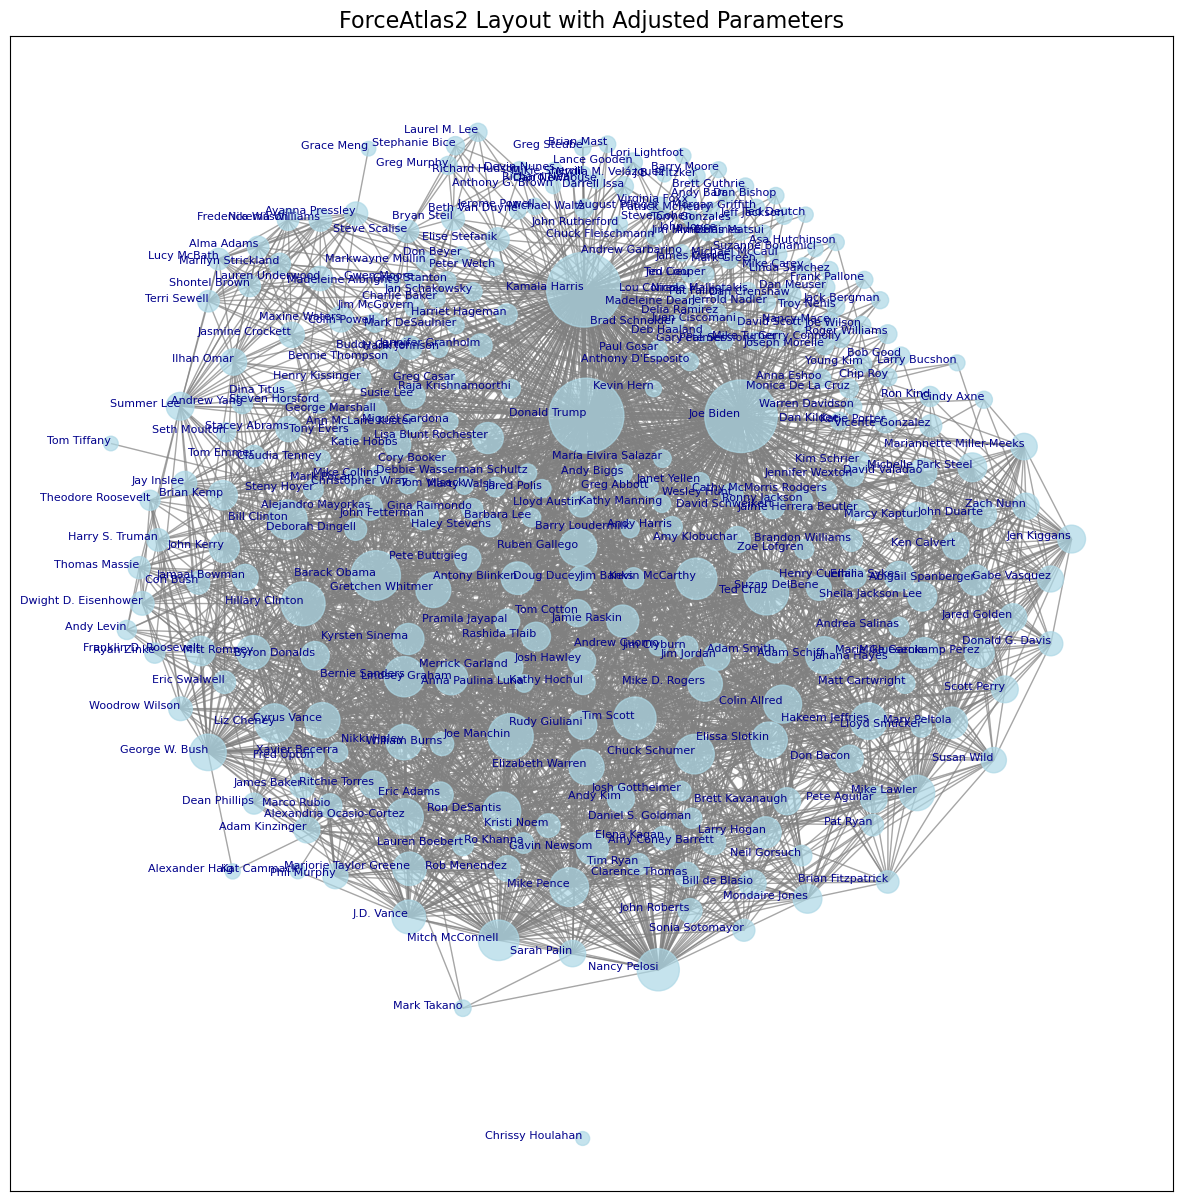

In [8]:
from fa2_modified import ForceAtlas2
import networkx as nx
import matplotlib.pyplot as plt

# Create the ForceAtlas2 instance with adjusted parameters
forceatlas2 = ForceAtlas2(
    jitterTolerance=1.0,  # Stability threshold
    barnesHutOptimize=True,  # Optimize layout for large graphs
    barnesHutTheta=1.5,  # Adjust theta for better spreading
    scalingRatio=100.0,  # Increase spacing between nodes
    strongGravityMode=True,  # Disable strong gravity
    gravity=0.01,  # Spread nodes outward
    verbose=True  # Output progress details
)

# Compute the ForceAtlas2 layout
positions = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

# Adjust node sizes dynamically based on degree
node_sizes = [100 + 10 * G.degree(n) for n in G.nodes()]

# Visualization
plt.figure(figsize=(15, 15))  # Increase figure size
nx.draw_networkx(
    G,
    pos=positions,
    with_labels=False,  # Temporarily hide labels
    node_size=node_sizes,  # Adjust node sizes
    node_color='lightblue',  # Set node color
    edge_color='gray',  # Set edge color
    alpha=0.7  # Set transparency
)

# Add labels separately to reduce overlap
for node, (x, y) in positions.items():
    plt.text(x, y, s=node, fontsize=8, ha='right', color='darkblue')

# Add a title
plt.title("ForceAtlas2 Layout with Adjusted Parameters", fontsize=16)

# Display the graph
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1235.28it/s]


BarnesHut Approximation  took  0.50  seconds
Repulsion forces  took  0.88  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


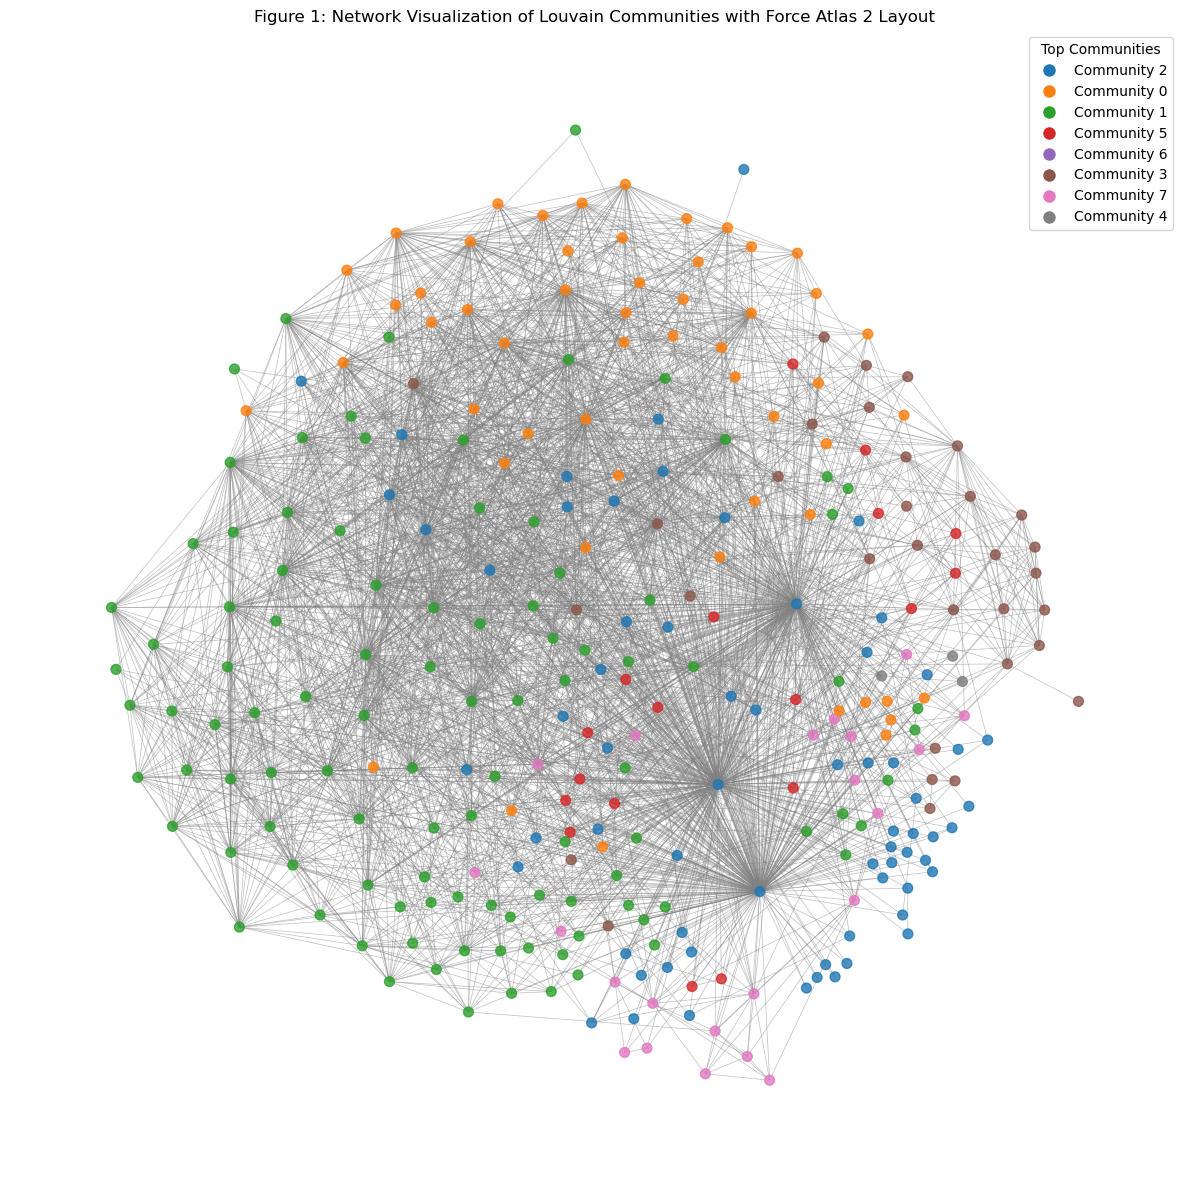

In [9]:
#make community detection
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from collections import Counter


# Compute the best partition
partition = community_louvain.best_partition(G)

# Analyze community structure
community_sizes = Counter(partition.values())
sorted_communities = community_sizes.most_common()

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

# Prepare visualization with colors for top communities
top_communities = [community for community, size in sorted_communities[:10]]
color_map = plt.get_cmap('tab10')
node_colors = []

for node in G.nodes():
    community_id = partition[node]
    node_colors.append(color_map(community_id % 10) if community_id in top_communities else 'lightgray')

# Compute Force Atlas 2 layout
forceatlas2 = ForceAtlas2(
     outboundAttractionDistribution=False,
     linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,  # Stability threshold
    barnesHutOptimize=True,  # Optimize layout for large graphs
    barnesHutTheta=1.5,  # Adjust theta for better spreading
    scalingRatio=100.0,  # Increase spacing between nodes
    strongGravityMode=True,  # Disable strong gravity
    gravity=0.01,  # Spread nodes outward
    verbose=True  # Output progress details
)
positions = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

# Draw the network with community colors
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, positions, node_size=50, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, positions, edge_color='gray', alpha=0.5, width=0.5)
plt.axis("off")

# Create legend for top communities
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=f"Community {community}",
               markerfacecolor=color_map(i % 10), markersize=10) 
    for i, (community, _) in enumerate(sorted_communities[:10])
]
plt.legend(handles=handles, loc="best", title="Top Communities")
plt.title("Figure 1: Network Visualization of Louvain Communities with Force Atlas 2 Layout")
plt.tight_layout()
plt.show()


In [10]:
#print the score
print("Modularity score:", community_louvain.modularity(partition, G))


Modularity score: 0.10985985078362871


# Remove outliers

In [12]:
# Identify isolated nodes (nodes with no edges)
isolated_nodes = list(nx.isolates(G))

# Remove the isolated nodes from the graph
G.remove_nodes_from(isolated_nodes)

# Check the updated graph information
print(f"Number of nodes after removing isolated nodes: {G.number_of_nodes()}")
print(f"Number of edges after removing isolated nodes: {G.number_of_edges()}")


Number of nodes after removing isolated nodes: 298
Number of edges after removing isolated nodes: 3308


# Plot graph with outliers removed

100%|██████████| 2000/2000 [00:01<00:00, 1136.64it/s]


BarnesHut Approximation  took  0.65  seconds
Repulsion forces  took  0.87  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds


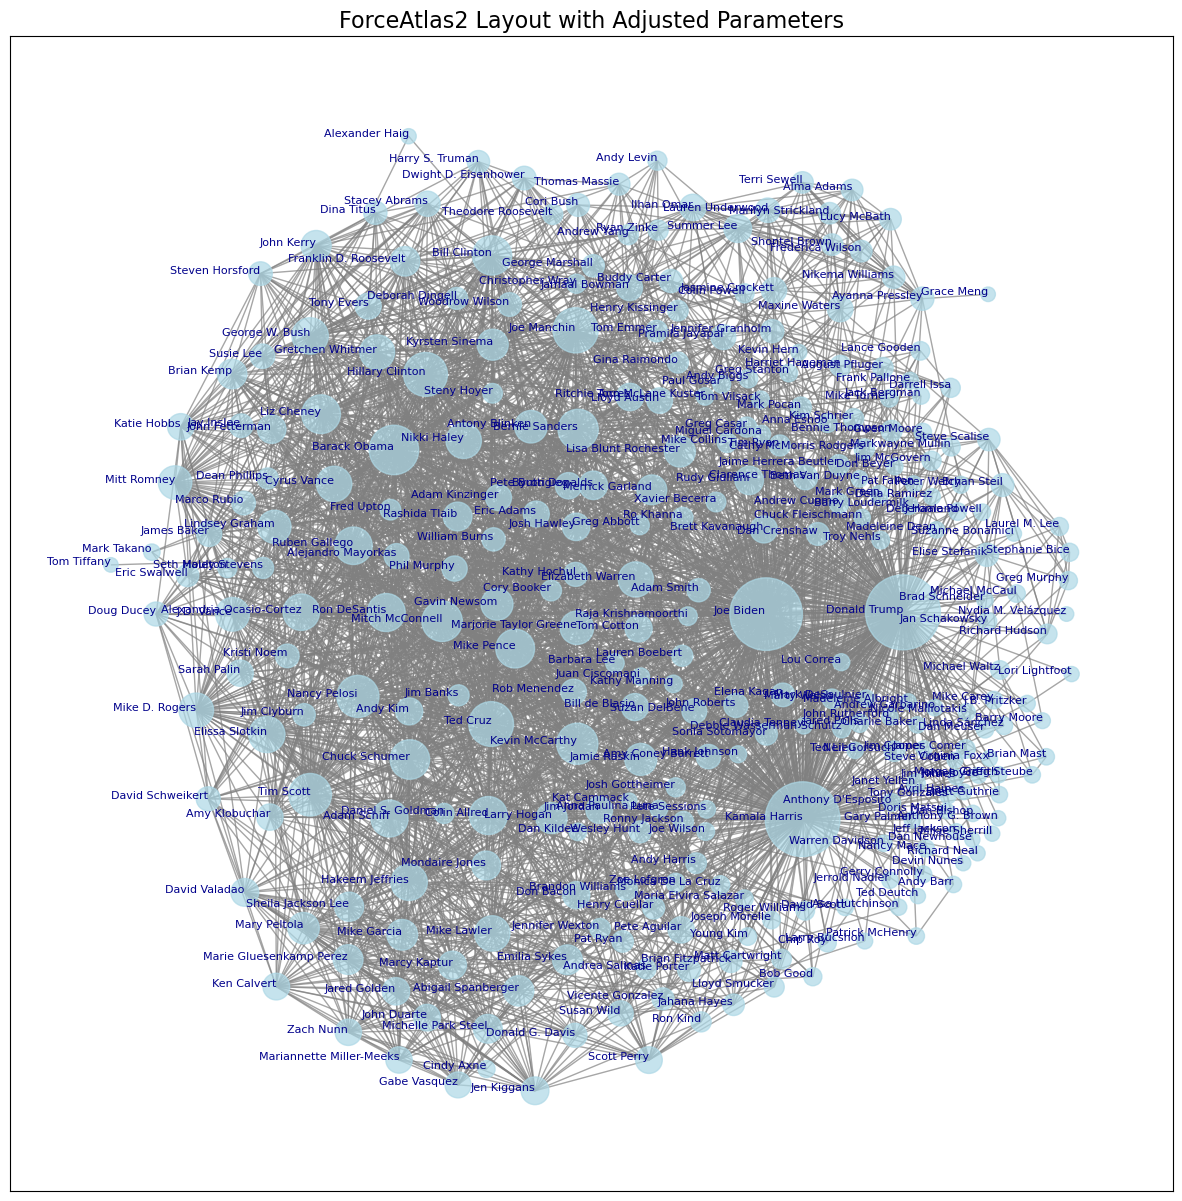

In [14]:
# Create the ForceAtlas2 instance with adjusted parameters
forceatlas2 = ForceAtlas2(
    jitterTolerance=1.0,  # Stability threshold
    barnesHutOptimize=True,  # Optimize layout for large graphs
    barnesHutTheta=1.5,  # Adjust theta for better spreading
    scalingRatio=100.0,  # Increase spacing between nodes
    strongGravityMode=True,  # Disable strong gravity
    gravity=0.01,  # Spread nodes outward
    verbose=True  # Output progress details
)

# Compute the ForceAtlas2 layout
positions = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

# Adjust node sizes dynamically based on degree
node_sizes = [100 + 10 * G.degree(n) for n in G.nodes()]

# Visualization
plt.figure(figsize=(15, 15))  # Increase figure size
nx.draw_networkx(
    G,
    pos=positions,
    with_labels=False,  # Temporarily hide labels
    node_size=node_sizes,  # Adjust node sizes
    node_color='lightblue',  # Set node color
    edge_color='gray',  # Set edge color
    alpha=0.7  # Set transparency
)

# Add labels separately to reduce overlap
for node, (x, y) in positions.items():
    plt.text(x, y, s=node, fontsize=8, ha='right', color='darkblue')

# Add a title
plt.title("ForceAtlas2 Layout with Adjusted Parameters", fontsize=16)

# Display the graph
plt.show()

# Sentiment analysis

In [28]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.colors as mcolors


In [16]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/thomasschioler/nltk_data...


True

Initialize 

In [17]:
sia = SentimentIntensityAnalyzer()

Compute Sentiment Scores for Each Article

In [ ]:
data_full_content['sentiment_scores'] = data_full_content['full_content'].apply(lambda content: sia.polarity_scores(content))



Assign Sentiment Scores to Politicians in the Network

In [29]:
# Step 3: Assign Sentiment Scores to Politicians in the Network
for politician in G.nodes():
    # Retrieve articles mentioning the politician
    articles = G.nodes[politician].get('articles', [])
    sentiments = []
    for article_idx in articles:
        # Retrieve the compound sentiment score for each article
        sentiment_scores = data_full_content.loc[article_idx, 'sentiment_scores']
        sentiments.append(sentiment_scores['compound'])  # Only store compound score
    # Store the list of sentiment scores and average sentiment as node attributes
    if sentiments:
        G.nodes[politician]['sentiments'] = sentiments
        G.nodes[politician]['average_sentiment'] = sum(sentiments) / len(sentiments)
    else:
        G.nodes[politician]['sentiments'] = []
        G.nodes[politician]['average_sentiment'] = None

Analyze and Visualize Sentiment Data

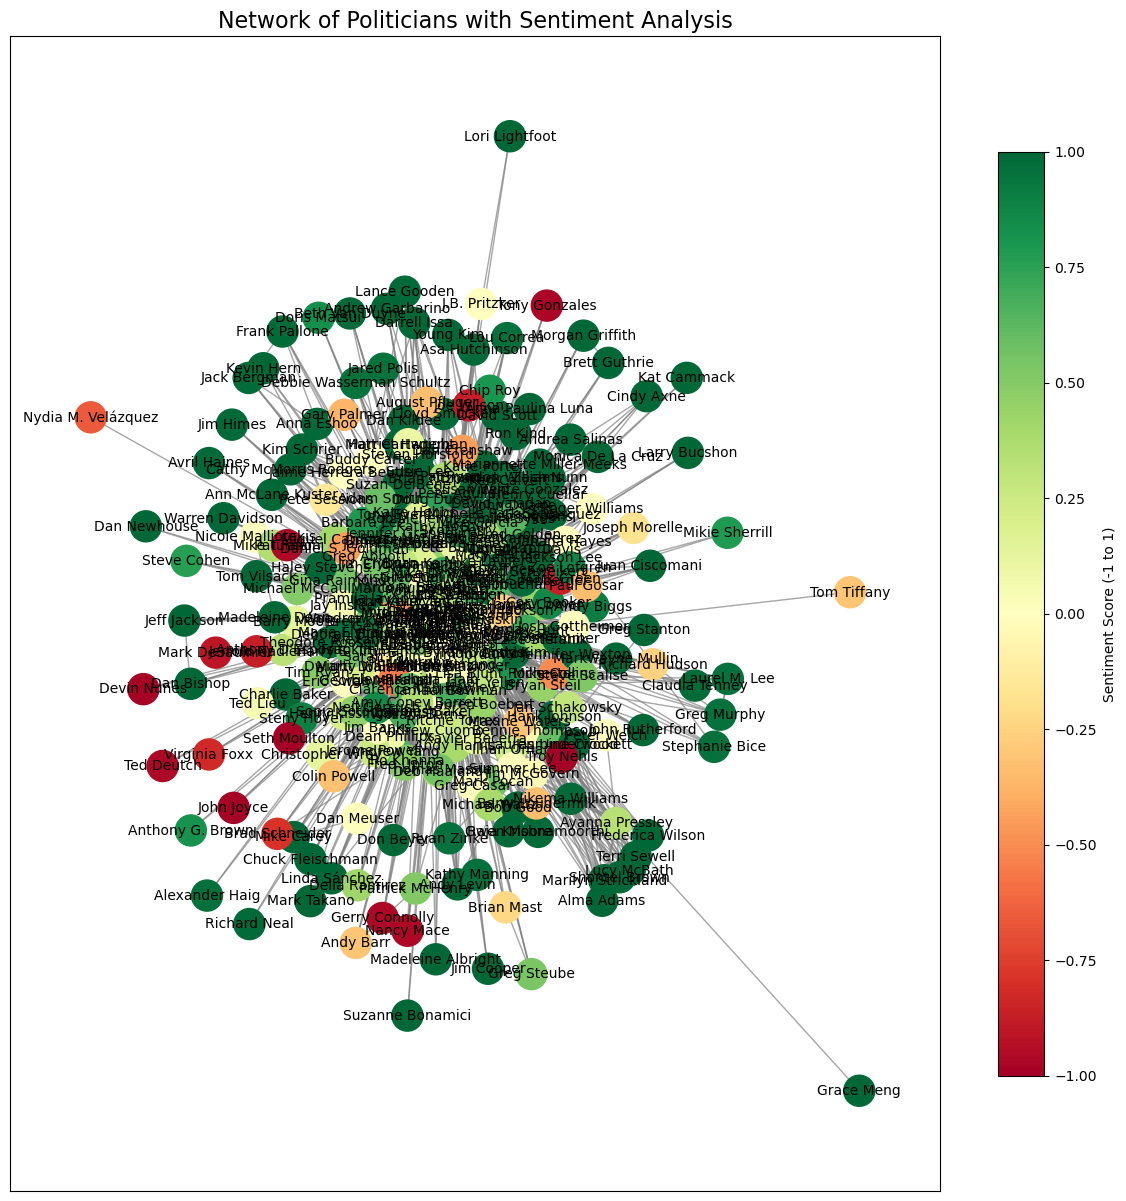

In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

# Create a colormap for sentiment scores
cmap = plt.cm.RdYlGn
norm = mcolors.Normalize(vmin=-1, vmax=1)

# Assign node colors based on average sentiment
node_colors = []
for politician in G.nodes():
    avg_sentiment = G.nodes[politician].get('average_sentiment')
    if avg_sentiment is not None:
        # Map sentiment to a color between red (-1) and green (+1)
        color = cmap(norm(avg_sentiment))
    else:
        color = 'gray'  # Default color for missing sentiment
    node_colors.append(color)

# Compute positions for visualization
positions = nx.spring_layout(G, seed=42)

# Create the figure and axis explicitly
fig, ax = plt.subplots(figsize=(15, 15))

# Draw the network
nx.draw_networkx_nodes(
    G,
    pos=positions,
    node_color=node_colors,
    node_size=500,
    ax=ax  # Specify the axis to draw on
)
nx.draw_networkx_edges(G, pos=positions, edge_color="gray", alpha=0.7, ax=ax)
nx.draw_networkx_labels(
    G, pos=positions, labels={node: node for node in G.nodes()}, font_size=10, ax=ax
)

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for ScalarMappable

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.8)
cbar.set_label("Sentiment Score (-1 to 1)")

# Add a title to the visualization
ax.set_title("Network of Politicians with Sentiment Analysis", fontsize=16)

# Show the graph
plt.show()


In [44]:
# Select a specific node to inspect
node_name = 'Donald Trump'  # Example node name

# Check if the node exists in the graph
if node_name in G.nodes:
    # Compare lengths of 'articles' and 'sentiments' arrays
    node_data = G.nodes[node_name]
    articles = node_data.get('articles', [])
    sentiments = node_data.get('sentiments', [])
    
    # Print the lengths of the arrays
    print(f"Node: {node_name}")
    print(f"Number of articles: {len(articles)}")
    
    # Print all sentiment scores
    print(f"Number of sentiment scores: {len(sentiments)}")
    # Print the attributes of the node
    print(f"Attributes for node '{node_name}':")
    for attribute, value in G.nodes[node_name].items():
        print(f"  {attribute}: {value}")
else:
    print(f"Node '{node_name}' not found in the graph.")


Node: Donald Trump
Number of articles: 6028
Number of sentiment scores: 6028
Attributes for node 'Donald Trump':
  articles: [0, 1, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 33, 34, 38, 40, 42, 43, 45, 48, 49, 50, 51, 52, 53, 55, 57, 58, 64, 65, 67, 69, 70, 71, 74, 75, 76, 77, 78, 82, 83, 84, 85, 86, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 191, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,

# Bipartite Network

- Group media outlets into Democratic-leaning and Republican-leaning.

- Use a bipartite structure with two kinds of nodes: Media and Politicians.

- Edges represent mentions of politicians, weighted by the number of mentions and sentiment.

Edge Attributes:
- Weight: The count of mentions.
- Sentiment: Aggregated sentiment score.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/thomasschioler/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Processed 1033 articles belonging to defined media categories.
Number of nodes: 157
Number of edges: 216
Average Sentiment by Media Category:
source
Democratic Media    0.450565
Republican Media    0.387972
Name: sentiment, dtype: float64


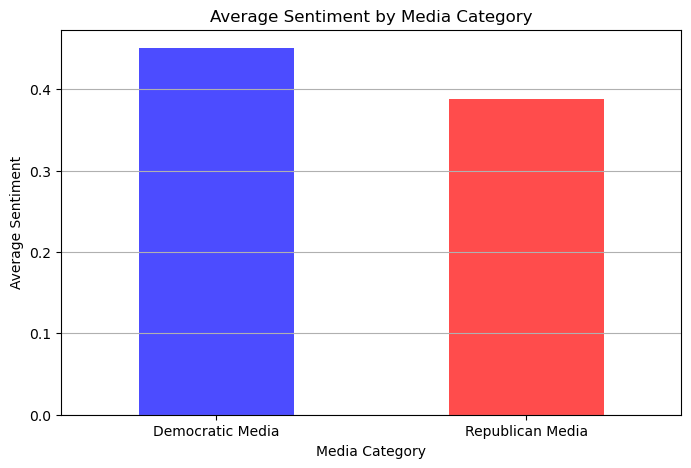

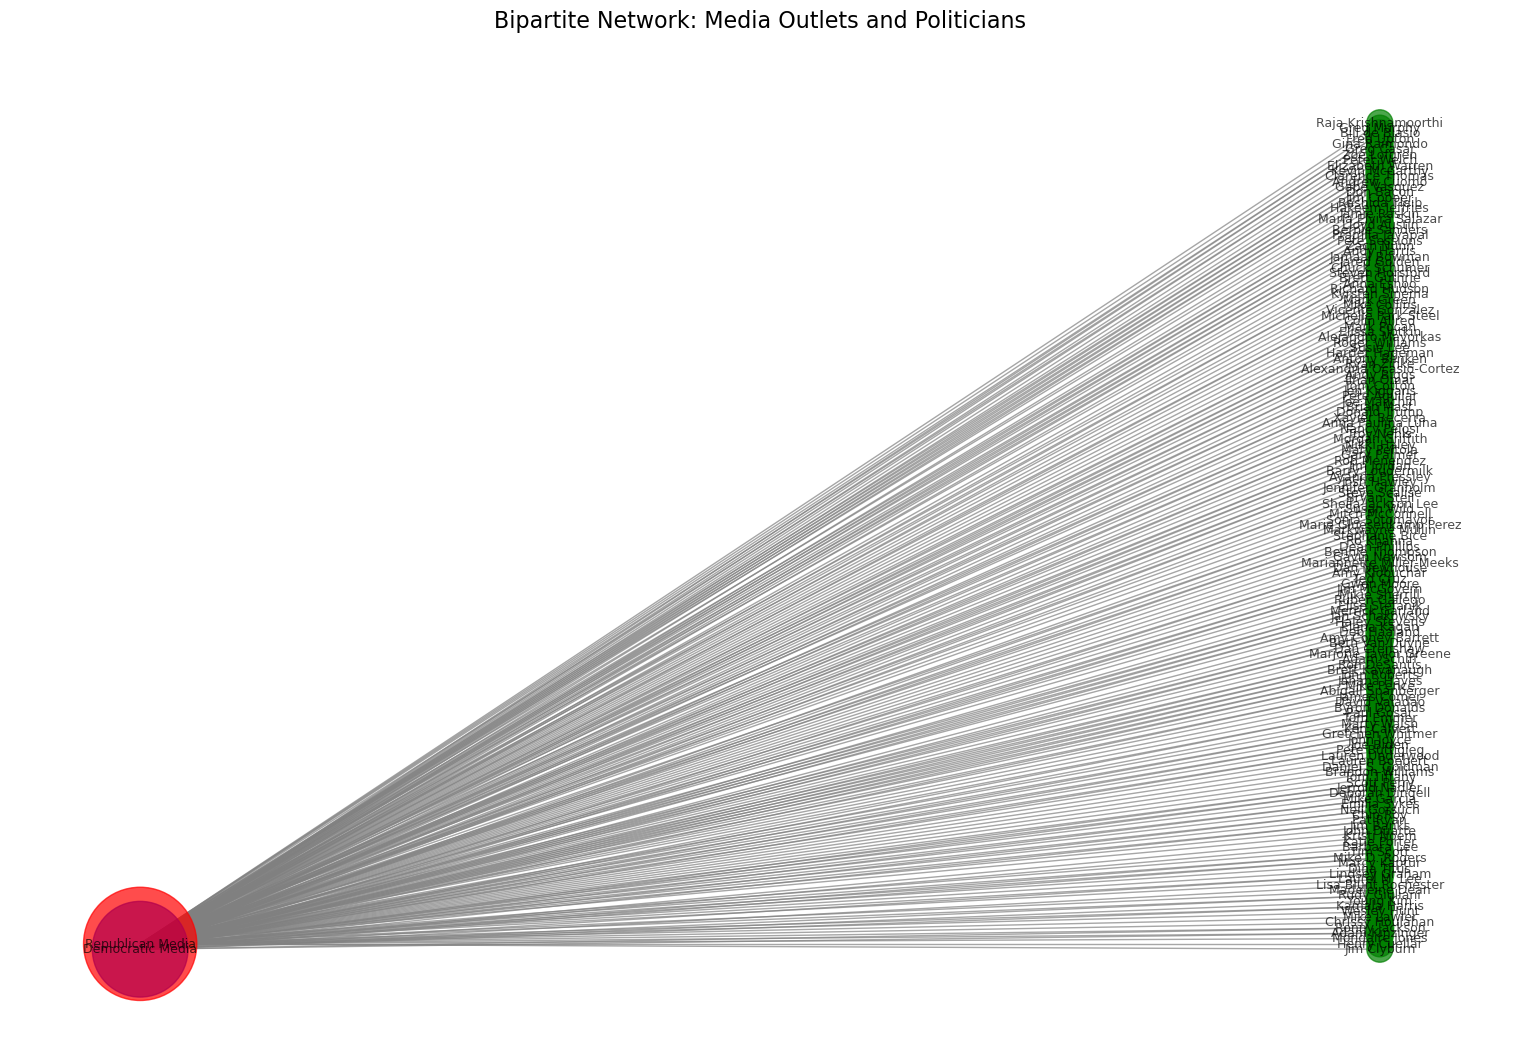

Edge Attribute Analysis:
           weight   sentiment
count  216.000000  216.000000
mean    12.523148    0.413763
std     58.816225    0.679387
min      1.000000   -0.999500
25%      1.000000   -0.002225
50%      2.000000    0.697296
75%      4.000000    0.994100
max    466.000000    0.999800


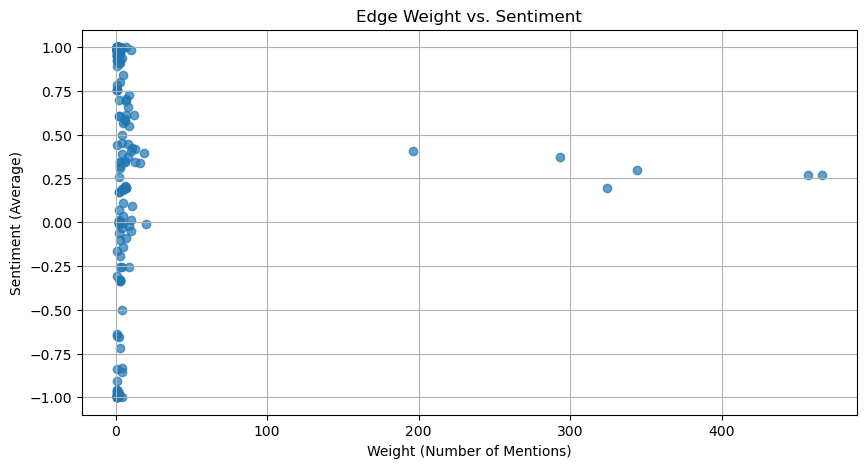


Top 10 Politicians Mentioned by Democratic Media:
              target  weight  sentiment
24      Donald Trump     344   0.300694
2      Kamala Harris     293   0.373541
48         Joe Biden     196   0.407414
51        Mike Pence      20  -0.010050
17          Ted Cruz      16   0.337712
76      Colin Allred      12   0.610217
70       Joe Manchin      10   0.985000
3      Rudy Giuliani       9  -0.020889
22       Nikki Haley       9   0.552433
40  Elizabeth Warren       7   0.998829


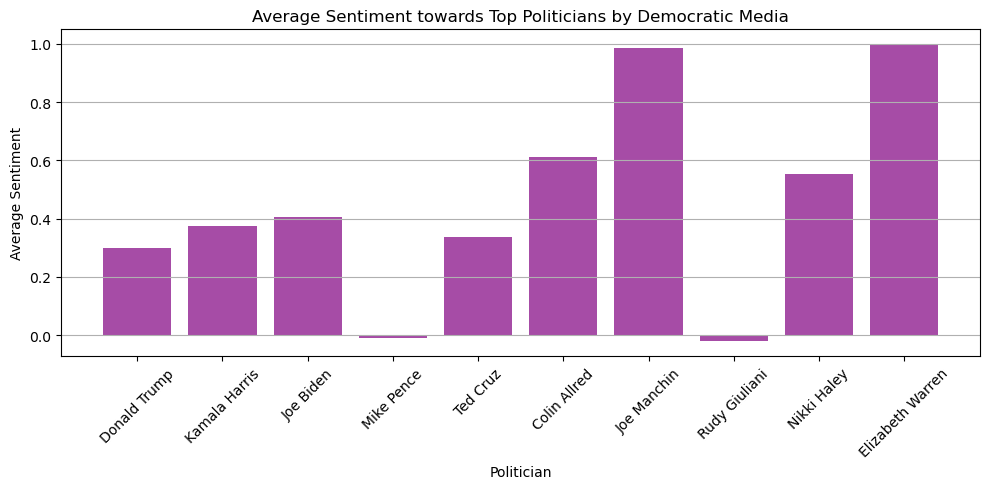


Top 10 Politicians Mentioned by Republican Media:
              target  weight  sentiment
130     Donald Trump     466   0.268921
92     Kamala Harris     457   0.268264
171        Joe Biden     324   0.196571
194      Joe Manchin      19   0.397816
117         Ted Cruz      13   0.342423
206   Bernie Sanders      13   0.419731
129     Nancy Pelosi      11   0.092555
109     John Roberts      11   0.421945
110     Ron DeSantis      10   0.012000
179  Merrick Garland      10  -0.049060


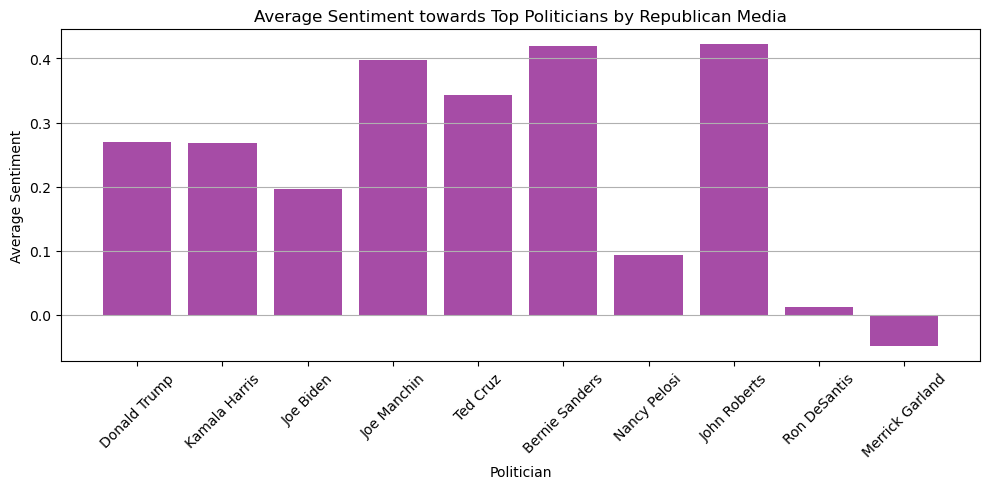

In [51]:
import re

# Download required NLTK data
nltk.download('vader_lexicon')

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Function to load manual politician data from JSON file
def load_manual_politicians(file_path="manual_politicians.json"):
    try:
        with open(file_path, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"File not found: {file_path}. Using an empty dictionary.")
        return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

# Load manual politicians (if available)
manual_politicians = load_manual_politicians()

# Function to retrieve U.S. politicians and their aliases
def get_current_us_congress_members():
    url = 'https://query.wikidata.org/sparql'
    query = '''
    SELECT DISTINCT ?person ?personLabel ?aliasLabel WHERE {
      VALUES ?position { wd:Q13217683 wd:Q13218630 }  # U.S. Senator and Representative
      ?person p:P39 ?positionStatement.
      ?positionStatement ps:P39 ?position;
                         pq:P580 ?startTime.
      FILTER NOT EXISTS { ?positionStatement pq:P582 ?endTime. }  # Position with no end time
      OPTIONAL { ?person skos:altLabel ?aliasLabel FILTER (LANG(?aliasLabel) = "en") }
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    '''
    headers = {'Accept': 'application/sparql-results+json'}
    response = requests.get(url, params={'query': query}, headers=headers, timeout=60)
    if response.status_code != 200:
        raise Exception(f"SPARQL query failed with status {response.status_code}: {response.text}")
    data = response.json()

    politician_aliases = {}
    for item in data['results']['bindings']:
        canonical_name = item['personLabel']['value']
        alias = item.get('aliasLabel', {}).get('value')
        if canonical_name not in politician_aliases:
            politician_aliases[canonical_name] = set()
            politician_aliases[canonical_name].add(canonical_name)
        if alias:
            politician_aliases[canonical_name].add(alias)
    return politician_aliases

# Fetch U.S. politician aliases
politician_aliases_raw = get_current_us_congress_members()

# Merge with manual politicians
politician_aliases_raw.update(manual_politicians)

# Build alias-to-canonical mapping
alias_to_canonical = {}
for canonical_name, aliases in politician_aliases_raw.items():
    for alias in aliases:
        alias_to_canonical[alias.lower()] = canonical_name

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Compute the compound sentiment score for each article and store it directly
data_full_content['compound_sentiment'] = data_full_content['full_content'].apply(
    lambda content: sia.polarity_scores(content)['compound'] if isinstance(content, str) else 0
)

# Function to map source names to media categories
def get_media_category(source):
    source = str(source).strip().lower()
    # Remove common prefixes and suffixes
    source = re.sub(r'^(the|www\.)\s+', '', source)
    source = re.sub(r'\.com$', '', source)
    source = source.replace('-', ' ')
    source = source.replace('.', ' ')
    source = source.replace(',', '')

    # Democratic media patterns
    democratic_patterns = [
        'cnn', 'msnbc', 'new york times', 'nyt', 'npr', 'guardian', 'huffpost', 'huffington post',
        'slate', 'vox', 'politico', 'buzzfeed', 'buzzfeed news'
    ]

    # Republican media patterns
    republican_patterns = [
        'fox news', 'fox', 'breitbart', 'wall street journal', 'wsj', 'washington times',
        'national review', 'daily caller', 'blaze', 'newsmax', 'federalist', 'oann',
        'one america news network'
    ]

    # Check for democratic media
    for pattern in democratic_patterns:
        if pattern in source:
            return 'Democratic Media'

    # Check for republican media
    for pattern in republican_patterns:
        if pattern in source:
            return 'Republican Media'

    return None  # Unknown media category

# Create a Bipartite Graph
B = nx.Graph()

# Add meta-nodes for media categories
B.add_node("Democratic Media", bipartite=0, type="Media")
B.add_node("Republican Media", bipartite=0, type="Media")

# Track politician mentions and sentiment for each category
democratic_mentions = defaultdict(list)
republican_mentions = defaultdict(list)

# Counter for processed articles
processed_articles = 0

# Process data to populate mentions
for idx, row in data_full_content.iterrows():
    content = row.get("full_content", "")
    source = row.get("source", "")
    sentiment = row.get('compound_sentiment', 0)

    # Get the media category
    category = get_media_category(source)
    if not category:
        continue  # Skip if media category is unknown

    processed_articles += 1

    # Identify politicians mentioned in the content
    doc = nlp(content)
    mentioned_politicians = set()
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            entity_name = ent.text.strip().lower()
            canonical_name = alias_to_canonical.get(entity_name)
            if canonical_name:
                mentioned_politicians.add(canonical_name)

    # Update mentions and sentiment for the category
    for politician in mentioned_politicians:
        if category == "Democratic Media":
            democratic_mentions[politician].append(sentiment)
        elif category == "Republican Media":
            republican_mentions[politician].append(sentiment)

print(f"Processed {processed_articles} articles belonging to defined media categories.")

# Add politician nodes and edges
all_politicians = set(democratic_mentions.keys()).union(republican_mentions.keys())

for politician in all_politicians:
    # Add politician node
    B.add_node(politician, bipartite=1, type="Politician")

    # Calculate edge attributes for Democratic media
    if politician in democratic_mentions:
        mention_count = len(democratic_mentions[politician])
        avg_sentiment = sum(democratic_mentions[politician]) / mention_count
        B.add_edge("Democratic Media", politician, weight=mention_count, sentiment=avg_sentiment)

    # Calculate edge attributes for Republican media
    if politician in republican_mentions:
        mention_count = len(republican_mentions[politician])
        avg_sentiment = sum(republican_mentions[politician]) / mention_count
        B.add_edge("Republican Media", politician, weight=mention_count, sentiment=avg_sentiment)

# Analyze the graph structure
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")

# Extract edge attributes (weight and sentiment)
edge_data = []
for u, v, data in B.edges(data=True):
    weight = data.get('weight', 0)
    sentiment = data.get('sentiment', 0)
    edge_data.append({'source': u, 'target': v, 'weight': weight, 'sentiment': sentiment})

# Convert to DataFrame for analysis
edge_df = pd.DataFrame(edge_data)

# Analyze sentiment by media category
media_categories = ["Democratic Media", "Republican Media"]
media_sentiments = edge_df[edge_df['source'].isin(media_categories)]
media_sentiments_grouped = media_sentiments.groupby('source')['sentiment'].mean()
print("Average Sentiment by Media Category:")
print(media_sentiments_grouped)

# Visualize sentiment trends by media category
media_sentiments_grouped.plot(kind='bar', figsize=(8, 5), color=['blue', 'red'], alpha=0.7)
plt.title("Average Sentiment by Media Category")
plt.xlabel("Media Category")
plt.ylabel("Average Sentiment")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Visualization of the Bipartite Network
from networkx.algorithms import bipartite

# Create a layout for bipartite graph
top_nodes = ["Democratic Media", "Republican Media"]
positions = {}
positions.update((node, (0, index)) for index, node in enumerate(top_nodes))
positions.update((node, (1, index)) for index, node in enumerate(B.nodes() - set(top_nodes)))

# Adjust node sizes dynamically based on degree
node_sizes = [300 + 50 * B.degree(n) for n in B.nodes()]

# Assign colors to nodes
node_colors = []
for node in B.nodes():
    if B.nodes[node]['type'] == "Media":
        node_colors.append("blue" if node == "Democratic Media" else "red")
    else:
        node_colors.append("green")

# Visualization
plt.figure(figsize=(15, 10))
nx.draw(
    B,
    pos=positions,
    with_labels=True,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="gray",
    alpha=0.7,
    font_size=9
)
plt.title("Bipartite Network: Media Outlets and Politicians", fontsize=16)
plt.axis('off')
plt.show()

# Analyze Edge Attributes
print("Edge Attribute Analysis:")
print(edge_df.describe())

# Analyze trends in weight and sentiment
plt.figure(figsize=(10, 5))
plt.scatter(edge_df['weight'], edge_df['sentiment'], alpha=0.7)
plt.title("Edge Weight vs. Sentiment")
plt.xlabel("Weight (Number of Mentions)")
plt.ylabel("Sentiment (Average)")
plt.grid(True)
plt.show()

# Additional Analysis: Sentiment Distribution per Politician per Media Category
for media in media_categories:
    media_edges = edge_df[edge_df['source'] == media]
    top_politicians = media_edges.sort_values(by='weight', ascending=False).head(10)
    print(f"\nTop 10 Politicians Mentioned by {media}:")
    print(top_politicians[['target', 'weight', 'sentiment']])

    # Plotting sentiment for top politicians
    plt.figure(figsize=(10, 5))
    plt.bar(top_politicians['target'], top_politicians['sentiment'], color='purple', alpha=0.7)
    plt.title(f"Average Sentiment towards Top Politicians by {media}")
    plt.xlabel("Politician")
    plt.ylabel("Average Sentiment")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()